In [1]:
# Install required libraries
!pip install pandas numpy scikit-learn seaborn matplotlib xgboost imblearn ipykernel joblib ipywidgets


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import ipywidgets as widgets
from IPython.display import display, HTML
%matplotlib inline

In [3]:
# Load datasets
train_df = pd.read_csv('loan-train.csv')
test_df = pd.read_csv('loan-test.csv')

# Display basic info
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# Display first 5 rows
print("\nFirst 5 rows of Training Data:")
print(train_df.head())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 36

Training Data - Numerical Columns Summary:
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  

Training Data - Categorical Columns Summary:
         Loan_ID Ge

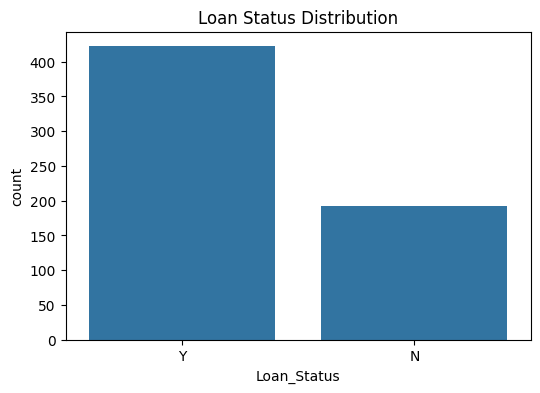

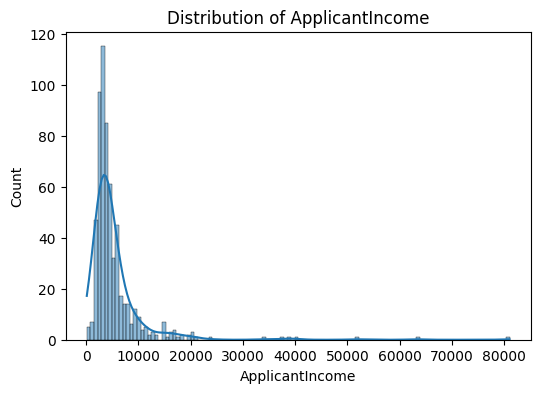

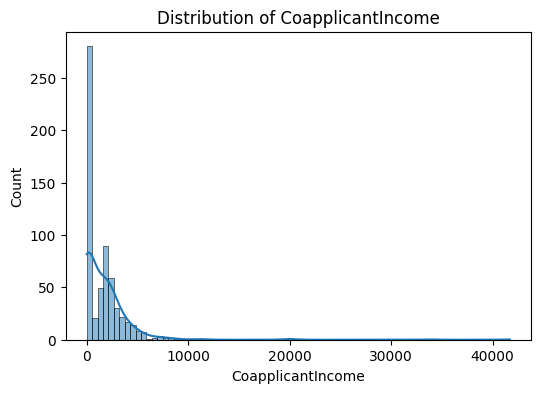

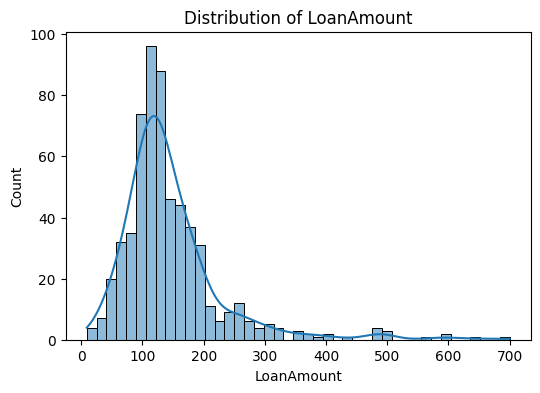

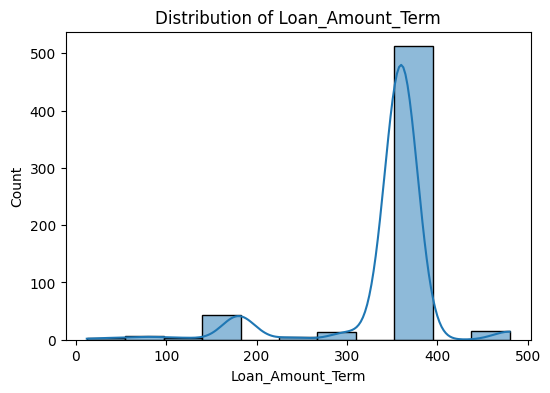

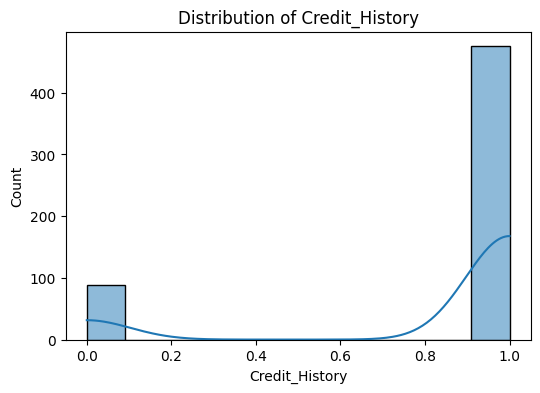

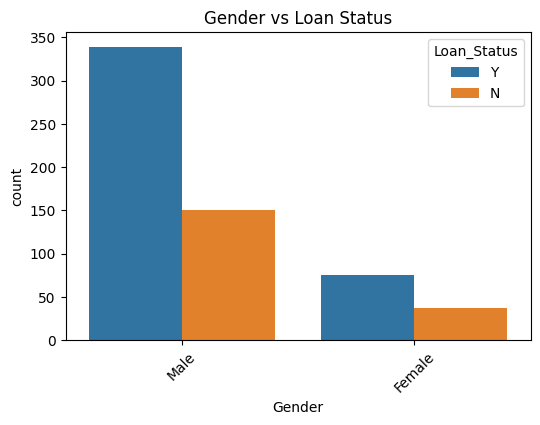

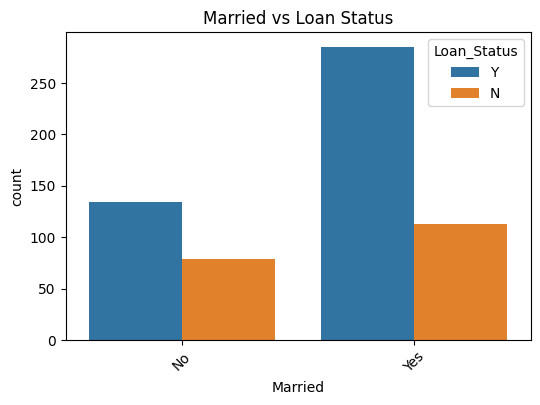

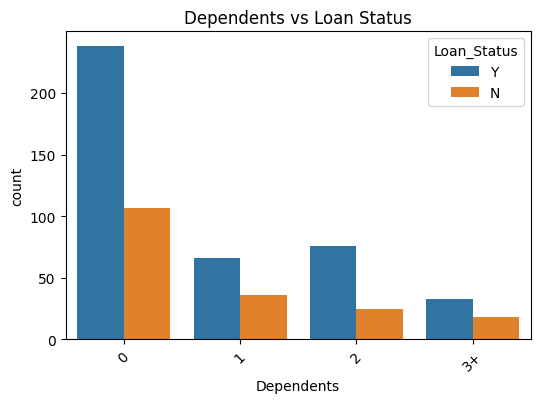

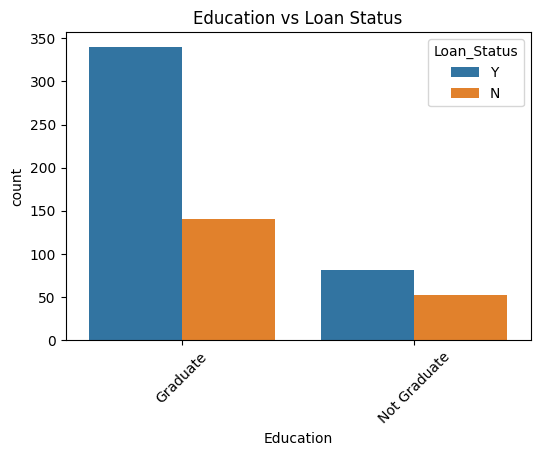

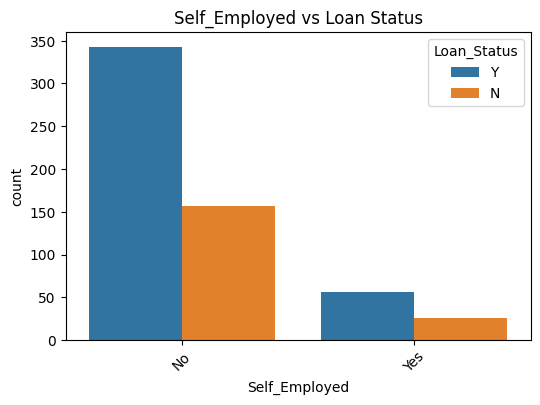

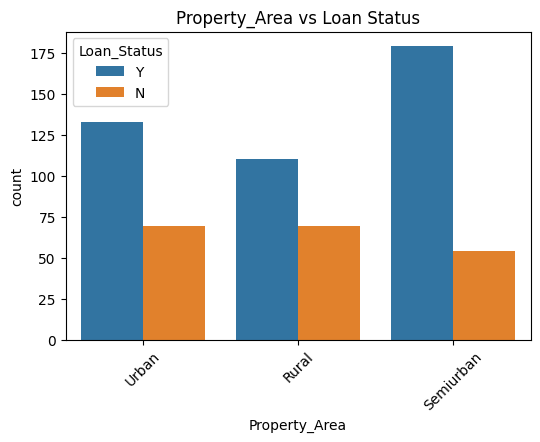

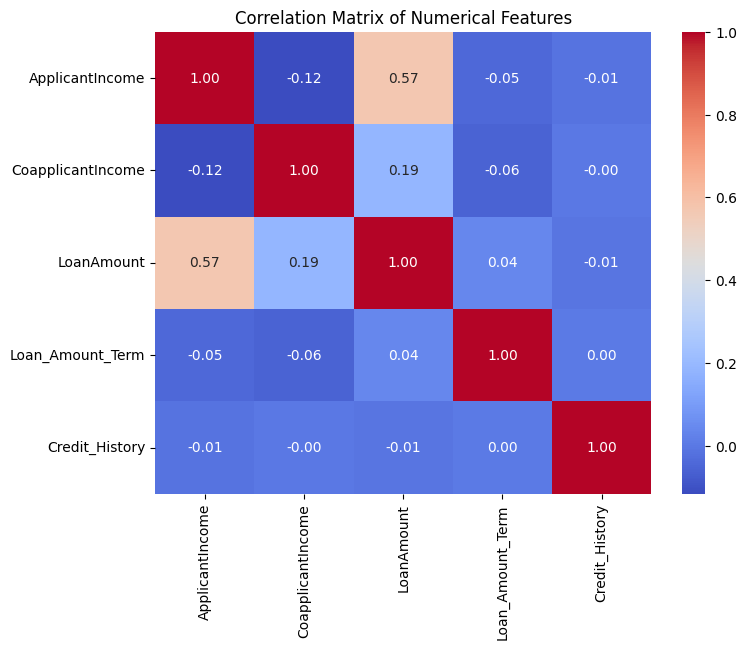

In [4]:
# Summary statistics
print("Training Data - Numerical Columns Summary:")
print(train_df.describe())
print("\nTraining Data - Categorical Columns Summary:")
print(train_df.select_dtypes(include='object').describe())

# Missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())

# Loan_Status distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=train_df)
plt.title('Loan Status Distribution')
plt.show()

# Numerical features distribution
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Categorical features vs Loan_Status
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='Loan_Status', data=train_df)
    plt.title(f'{col} vs Loan Status')
    plt.xticks(rotation=45)
    plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [5]:
# Feature engineering
train_df['Total_Income'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']
test_df['Total_Income'] = test_df['ApplicantIncome'] + test_df['CoapplicantIncome']

train_df['Loan_Income_Ratio'] = train_df['LoanAmount'] / train_df['Total_Income']
test_df['Loan_Income_Ratio'] = test_df['LoanAmount'] / train_df['Total_Income']

train_df['Has_Coapplicant'] = train_df['CoapplicantIncome'].apply(lambda x: 1 if x > 0 else 0)
test_df['Has_Coapplicant'] = test_df['CoapplicantIncome'].apply(lambda x: 1 if x > 0 else 0)

train_df['Log_ApplicantIncome'] = np.log1p(train_df['ApplicantIncome'])
test_df['Log_ApplicantIncome'] = np.log1p(test_df['ApplicantIncome'])
train_df['Log_LoanAmount'] = np.log1p(train_df['LoanAmount'])
test_df['Log_LoanAmount'] = np.log1p(test_df['LoanAmount'])

# Cap outliers
for col in ['Log_ApplicantIncome', 'Log_LoanAmount', 'Total_Income', 'Loan_Income_Ratio']:
    lower = train_df[col].quantile(0.01)
    upper = train_df[col].quantile(0.99)
    train_df[col] = train_df[col].clip(lower, upper)
    test_df[col] = test_df[col].clip(lower, upper)

# Feature lists
new_numerical_cols = ['Log_ApplicantIncome', 'Log_LoanAmount', 'Loan_Amount_Term', 
                      'Credit_History', 'Total_Income', 'Loan_Income_Ratio']
new_categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 
                        'Self_Employed', 'Property_Area', 'Has_Coapplicant']
features = new_numerical_cols + new_categorical_cols
print("New Features in Training Data:")
print(train_df[features].head())

New Features in Training Data:
   Log_ApplicantIncome  Log_LoanAmount  Loan_Amount_Term  Credit_History  \
0             8.674197             NaN             360.0             1.0   
1             8.430327        4.859812             360.0             1.0   
2             8.006701        4.204693             360.0             1.0   
3             7.857094        4.795791             360.0             1.0   
4             8.699681        4.955827             360.0             1.0   

   Total_Income  Loan_Income_Ratio Gender Married Dependents     Education  \
0        5849.0                NaN   Male      No          0      Graduate   
1        6091.0           0.021015   Male     Yes          1      Graduate   
2        3000.0           0.022000   Male     Yes          0      Graduate   
3        4941.0           0.024287   Male     Yes          0  Not Graduate   
4        6000.0           0.023500   Male      No          0      Graduate   

  Self_Employed Property_Area  Has_Coapplic

In [6]:
# Prepare data
X = train_df[features]
y = train_df['Loan_Status'].map({'Y': 1, 'N': 0})
X_test = test_df[features]

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, new_numerical_cols),
        ('cat', categorical_transformer, new_categorical_cols)
    ])

# Feature selection
selector_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(random_state=42)))
])
selector_pipeline.fit(X_train, y_train)

# Get selected features
selected_features_idx = selector_pipeline.named_steps['selector'].get_support()
selected_features = [f for f, s in zip(features, selected_features_idx) if s]
new_numerical_cols_selected = [f for f in new_numerical_cols if f in selected_features]
new_categorical_cols_selected = [f for f in new_categorical_cols if f in selected_features]
print("Selected Features:", selected_features)
print("Updated Numerical Columns:", new_numerical_cols_selected)
print("Updated Categorical Columns:", new_categorical_cols_selected)

# Update datasets
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

Selected Features: ['Log_ApplicantIncome', 'Log_LoanAmount', 'Credit_History', 'Total_Income', 'Loan_Income_Ratio']
Updated Numerical Columns: ['Log_ApplicantIncome', 'Log_LoanAmount', 'Credit_History', 'Total_Income', 'Loan_Income_Ratio']
Updated Categorical Columns: []


In [7]:
# Update preprocessing
preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, new_numerical_cols_selected),
        ('cat', categorical_transformer, new_categorical_cols_selected)
    ])

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42)
}

# Train and evaluate
results = []
for name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_selected),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    pipeline.fit(X_train_selected, y_train)
    y_pred = pipeline.predict(X_val_selected)
    y_proba = pipeline.predict_proba(X_val_selected)[:, 1] if hasattr(pipeline, 'predict_proba') else None
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba) if y_proba is not None else 'N/A'
    results.append({
        'Model': name,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc
    })
    print(f"\nResults for {name} with SMOTE:")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}")
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

results_df = pd.DataFrame(results)
print("\nModel Comparison with SMOTE:\n", results_df.sort_values(by='F1-Score', ascending=False))


Results for Random Forest with SMOTE:
F1-Score: 0.7950
Accuracy: 0.7317
ROC-AUC: 0.7488372093023256

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61        43
           1       0.79      0.80      0.80        80

    accuracy                           0.73       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.73      0.73      0.73       123


Results for Logistic Regression with SMOTE:
F1-Score: 0.8667
Accuracy: 0.8049
ROC-AUC: 0.6950581395348838

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.49      0.64        43
           1       0.78      0.97      0.87        80

    accuracy                           0.80       123
   macro avg       0.85      0.73      0.75       123
weighted avg       0.83      0.80      0.79       123


Results for SVM with SMOTE:
F1-Score: 0.8778
Accuracy: 0.8211
ROC-AUC: 0.74215116279069

In [8]:
# Select top 2 models
top_models = results_df.nlargest(2, 'F1-Score')['Model'].values
print("\nTop 2 Models for Tuning:", top_models)

# Parameter grids
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

# Tune models
tuned_results = []
for name in top_models:
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_selected),
        ('smote', SMOTE(random_state=42)),
        ('classifier', models[name])
    ])
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)
    y_pred = grid_search.predict(X_val_selected)
    y_proba = grid_search.predict_proba(X_val_selected)[:, 1] if hasattr(grid_search, 'predict_proba') else None
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba) if y_proba is not None else 'N/A'
    tuned_results.append({
        'Model': name,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Best Parameters': grid_search.best_params_
    })
    print(f"\nTuned Results for {name}:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}")
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

tuned_results_df = pd.DataFrame(tuned_results)
print("\nTuned Model Comparison:\n", tuned_results_df.sort_values(by='F1-Score', ascending=False))


Top 2 Models for Tuning: ['SVM' 'Logistic Regression']

Tuned Results for SVM:
Best Parameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
F1-Score: 0.8587
Accuracy: 0.7886
ROC-AUC: 0.7546511627906977

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


Tuned Results for Logistic Regression:
Best Parameters: {'classifier__C': 0.1}
F1-Score: 0.8619
Accuracy: 0.7967
ROC-AUC: 0.715406976744186

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.47      0.62        43
           1       0.77      0.97      0.86        80

    accuracy                           0.80       123
   macro avg       0.84      0.72      0.74       

In [9]:
# Select best tuned model
best_model_name = tuned_results_df.loc[tuned_results_df['F1-Score'].idxmax(), 'Model']
best_f1 = tuned_results_df['F1-Score'].max()
best_params = tuned_results_df.loc[tuned_results_df['F1-Score'].idxmax(), 'Best Parameters']
print(f"\nBest Tuned Model: {best_model_name} with F1-Score: {best_f1:.4f}")
print(f"Best Parameters: {best_params}")

# Define and retrain best pipeline
best_model = models[best_model_name].set_params(**{k.split('__')[1]: v for k, v in best_params.items()})
best_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_model)
])
best_pipeline.fit(X, y)

# Save model to disk
model_filename = 'best_loan_model.pkl'
joblib.dump(best_pipeline, model_filename)
print(f"Best model saved as '{model_filename}'")

# Cross-validation
cv_results = cross_validate(best_pipeline, X, y, cv=5, scoring=['f1', 'accuracy', 'roc_auc'], return_train_score=False)
print("\nCross-Validation Results:")
print(f"Mean F1-Score: {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"Mean ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")


Best Tuned Model: Logistic Regression with F1-Score: 0.8619
Best Parameters: {'classifier__C': 0.1}
Best model saved as 'best_loan_model.pkl'

Cross-Validation Results:
Mean F1-Score: 0.8754 (+/- 0.0206)
Mean Accuracy: 0.8110 (+/- 0.0324)
Mean ROC-AUC: 0.7324 (+/- 0.0435)


In [10]:
# Predict on test data
test_predictions = best_pipeline.predict(X_test_selected)

# Add predictions to test dataframe
test_df['Loan_Status'] = ['Y' if pred == 1 else 'N' for pred in test_predictions]

# Save predictions
test_df[['Loan_ID', 'Loan_Status']].to_csv('loan_predictions.csv', index=False)

